In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

# Modules for generating waveforms
import pycbc.types # TimeSeries
import pycbc.waveform # Waveforms

# cbcrom modules
sys.path.insert(0, '../cbcrom')
import timedomainrom as tdrom
import timeseriesutils as tsutils

Populating the interactive namespace from numpy and matplotlib



# Load ROM and evaluate waveform

In [2]:
memb_size=2**26-1
Bamp_filename = '../data/Bamp_%d.hdf5'
Bphase_filename = '../data/Bphase_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs.hdf5'
phasecoeff_filename = '../data/phase_coeffs.hdf5'
rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

In [3]:
distance, inclination, f_lower, delta_t = 100.0, 0.0, 50.0, 1.0/2**14
mass1, mass2, lambda1, lambda2 = 1.0, 1.0, 5000.0, 5000.0

tstart, delta_t, hplus, hcross = rom.evaluate_physical_units(
    mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2,
    delta_t=delta_t, f_lower=f_lower, f_ref=None,
    distance=distance, inclination=inclination, coa_phase=None)

print tstart, delta_t
print hplus 
print hcross
print len(hplus), len(hcross)

-24.5046895907 6.103515625e-05
[  1.25398608e-23   1.25375633e-23   1.25306562e-23 ...,   5.19766082e-23
  -1.55563174e-24  -5.63881132e-23]
[  0.00000000e+00   2.40434345e-25   4.80780812e-25 ...,   9.54713693e-23
   1.09175874e-22   9.09359405e-23]
401487 401487


# Compare ROM to pyCBC TaylorT4

In [4]:
def reduced_order_model_time_series(rom, **kwargs):
    """Convert ROM to pycbc TimeSeries.
    """
    tstart, delta_t, hp, hc = rom.evaluate_physical_units(**kwargs)
    hplus = pycbc.types.TimeSeries(hp, epoch=tstart, delta_t=delta_t)
    hcross = pycbc.types.TimeSeries(hc, epoch=tstart, delta_t=delta_t)
    return hplus, hcross

In [5]:
def zero_start_time_phase(hp, hc):
    """Set the time and phase of the first data point to zero.
    """
    amp, phase = tsutils.amp_phase_from_polarizations(hp, hc, remove_start_phase=True)
    hcomplex = tsutils.complex_from_amp_phase(amp, phase)
    hcomplex.start_time -= hcomplex.start_time
    return hcomplex

In [6]:
# Evaluate 2 ROM waveforms
distance, inclination, f_lower, delta_t = 100.0, 0.0, 50.0, 1.0/2**14

mass1, mass2, lambda1, lambda2 = 1.0, 1.0, 5000.0, 5000.0
hp1ROM, hc1ROM = reduced_order_model_time_series(rom, mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                                        delta_t=delta_t, f_lower=f_lower, f_ref=None, 
                                        distance=distance, inclination=inclination, coa_phase=None)

mass1, mass2, lambda1, lambda2 = 2.0, 1.0, 50.0, 5000.0
hp2ROM, hc2ROM = reduced_order_model_time_series(rom, mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                                        delta_t=delta_t, f_lower=f_lower, f_ref=None, 
                                        distance=distance, inclination=inclination, coa_phase=None)

In [7]:
# Evaluate 2 TaylorT4 waveforms with same parameters as the ROM wavefroms
distance, inclination, f_lower, delta_t = 100.0, 0.0, 50.0, 1.0/2**14

mass1, mass2, lambda1, lambda2 = 1.0, 1.0, 5000.0, 5000.0
hp1T4, hc1T4 = pycbc.waveform.get_td_waveform(approximant='TaylorT4', 
                        mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                        distance=distance, inclination=inclination, 
                        delta_t=delta_t, f_lower=f_lower, f_ref=f_lower, 
                        phase_order=7, tidal_order=12, amplitude_order=6)

mass1, mass2, lambda1, lambda2 = 2.0, 1.0, 50.0, 5000.0
hp2T4, hc2T4 = pycbc.waveform.get_td_waveform(approximant='TaylorT4', 
                        mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                        distance=distance, inclination=inclination, 
                        delta_t=delta_t, f_lower=f_lower, f_ref=f_lower, 
                        phase_order=7, tidal_order=12, amplitude_order=6)

In [8]:
h1ROM = zero_start_time_phase(hp1ROM, hc1ROM)
h2ROM = zero_start_time_phase(hp2ROM, hc2ROM)
h1T4 = zero_start_time_phase(hp1T4, hc1T4)
h2T4 = zero_start_time_phase(hp2T4, hc2T4)

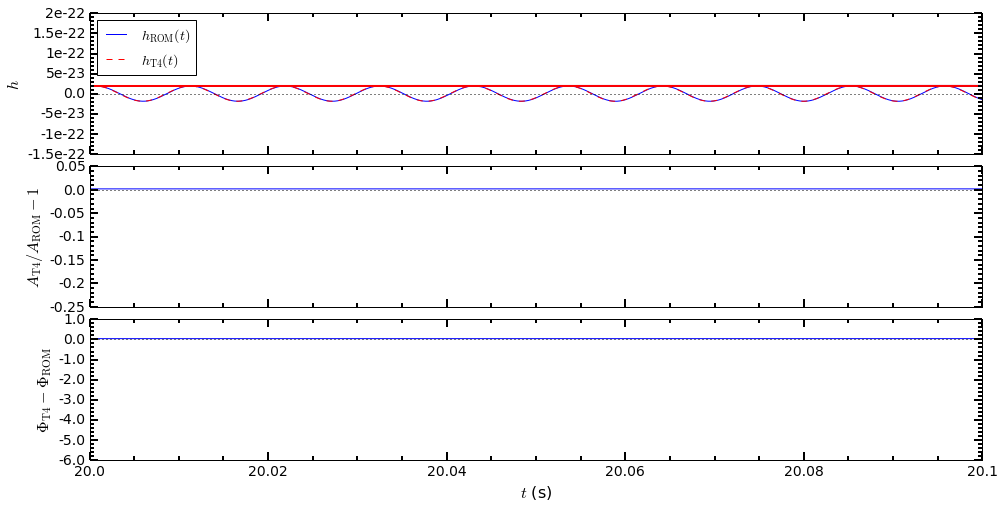

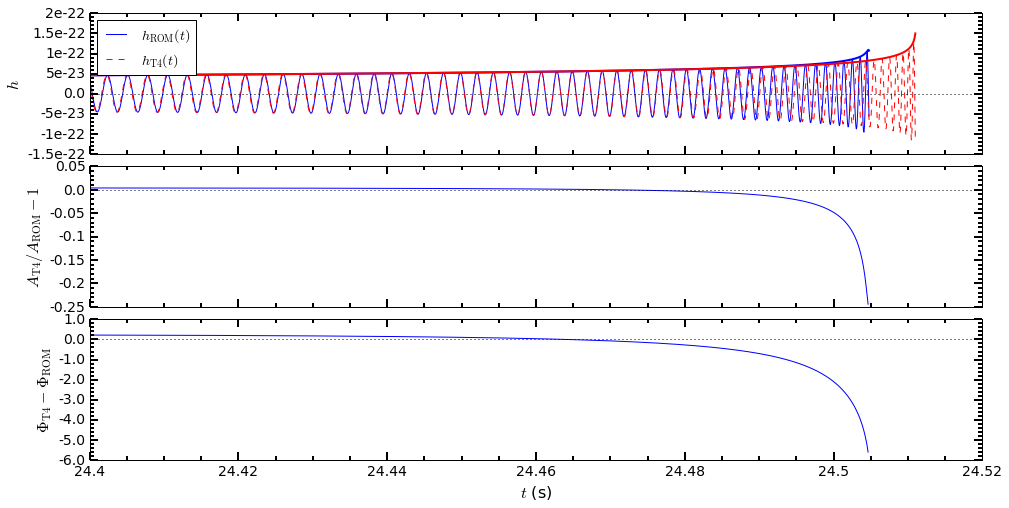

In [9]:
# Compare h1ROM to h1T4
fig = plt.figure(figsize=(16, 8))
tsutils.compare_two_waveforms(fig, h1ROM, h1T4, mag=True, xlim=[20, 20.1],
                              remove_start_phase=True,
                              xlabel=r'$t$ (s)', ylabel_wave=r'$h$',
                              ylabel_amp=r'$A_{\rm T4}/A_{\rm ROM} - 1$',
                              ylabel_phase=r'$\Phi_{\rm T4} - \Phi_{\rm ROM}$',
                              labels=[r'$h_{\rm ROM}(t)$', r'$h_{\rm T4}(t)$'])


fig = plt.figure(figsize=(16, 8))
tsutils.compare_two_waveforms(fig, h1ROM, h1T4, mag=True, xlim=[24.4, 24.52],
                              remove_start_phase=True,
                              xlabel=r'$t$ (s)', ylabel_wave=r'$h$',
                              ylabel_amp=r'$A_{\rm T4}/A_{\rm ROM} - 1$',
                              ylabel_phase=r'$\Phi_{\rm T4} - \Phi_{\rm ROM}$',
                              labels=[r'$h_{\rm ROM}(t)$', r'$h_{\rm T4}(t)$'])

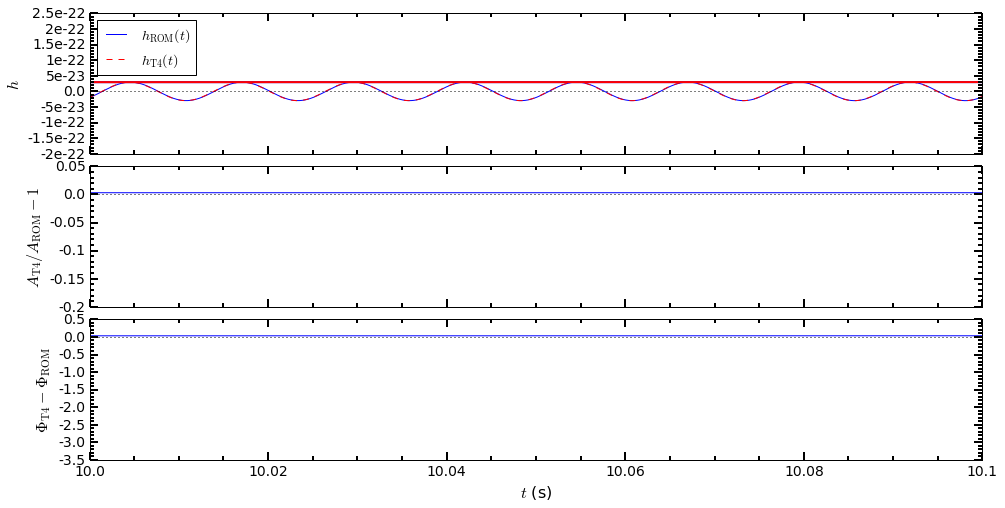

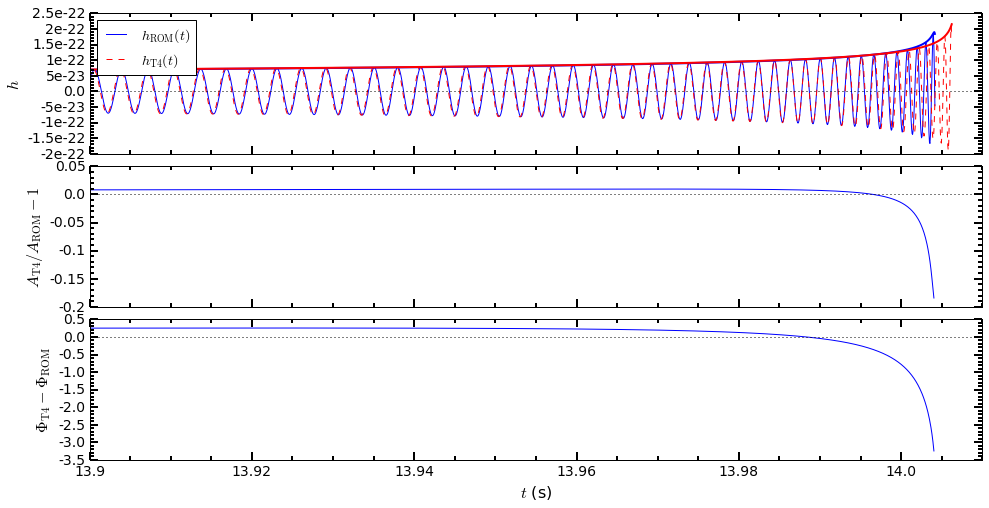

In [10]:
# Compare h2ROM to h2T4
fig = plt.figure(figsize=(16, 8))
tsutils.compare_two_waveforms(fig, h2ROM, h2T4, mag=True, xlim=[10.0, 10.1],
                              remove_start_phase=True,
                              xlabel=r'$t$ (s)', ylabel_wave=r'$h$',
                              ylabel_amp=r'$A_{\rm T4}/A_{\rm ROM} - 1$',
                              ylabel_phase=r'$\Phi_{\rm T4} - \Phi_{\rm ROM}$',
                              labels=[r'$h_{\rm ROM}(t)$', r'$h_{\rm T4}(t)$'])

fig = plt.figure(figsize=(16, 8))
tsutils.compare_two_waveforms(fig, h2ROM, h2T4, mag=True, xlim=[13.9, 14.01],
                              remove_start_phase=True,
                              xlabel=r'$t$ (s)', ylabel_wave=r'$h$',
                              ylabel_amp=r'$A_{\rm T4}/A_{\rm ROM} - 1$',
                              ylabel_phase=r'$\Phi_{\rm T4} - \Phi_{\rm ROM}$', 
                              labels=[r'$h_{\rm ROM}(t)$', r'$h_{\rm T4}(t)$'])